In [9]:
import pandas as pd
import numpy as np

import altair as alt
import hela.visualization.hmm as hmmplot
import matplotlib.pyplot as plt
%matplotlib inline

from hela import hmm
import hela.generation.hmm as gen
from scipy.special import logsumexp

from datetime import datetime
from dask.distributed import Client

TU_COLORS = [
    "#9b67ff", "#57b3c2", "#ffa040", "#ff6283", "#2ccc72", "#1270cb", "#bd043a",
    "#a1c54d", "#4c319e", "#c6c0fe", "#195036", "#f6a39f"
]

In [10]:
factored_generative_model = gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2,3,2],
                                     n_gaussian_features = 3)
#                                      n_categorical_features = 1)

ValueError: could not broadcast input array from shape (3,2) into shape (3)

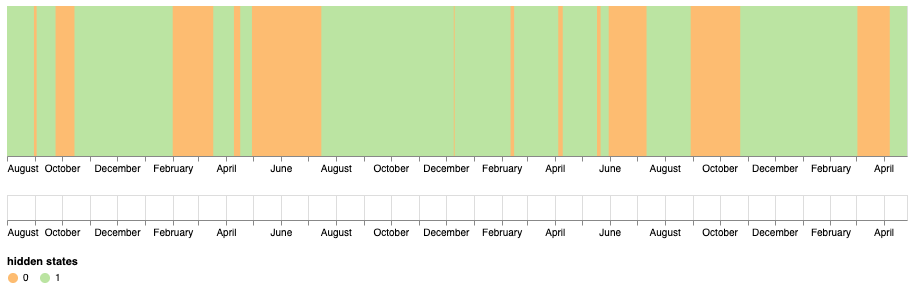

In [3]:
factored_hidden_states = fgm.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(factored_hidden_states[0], hide_brush=False)

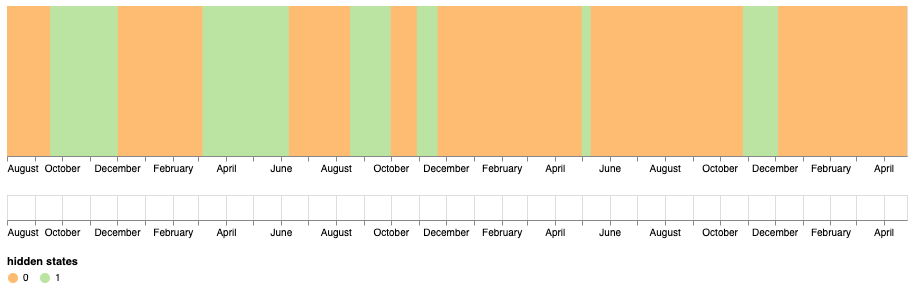

In [4]:
hmmplot.draw_states(factored_hidden_states[1], hide_brush=False)

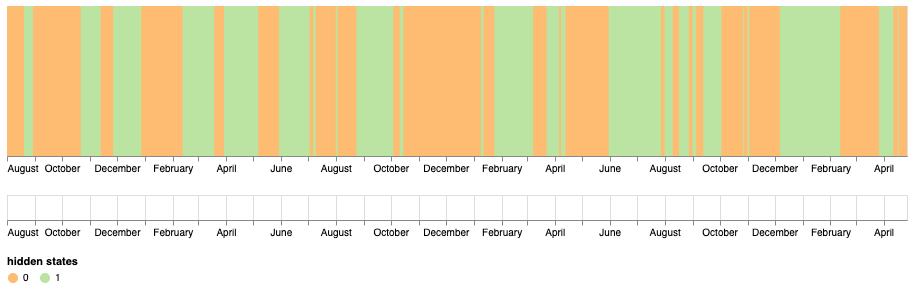

In [5]:
hmmplot.draw_states(factored_hidden_states[2], hide_brush=False)

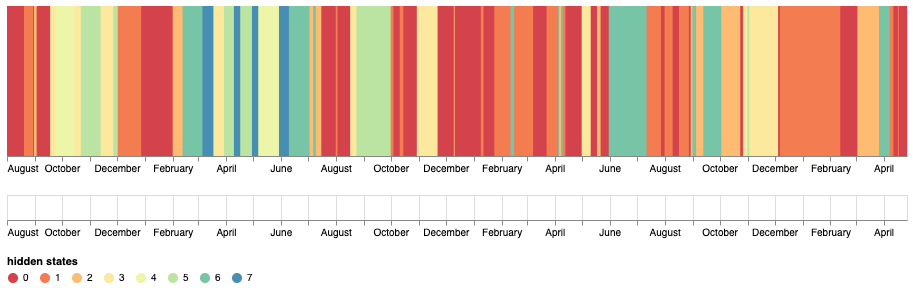

In [6]:
flattened_hidden_states = fgm.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [17]:
def g_observations(self, hidden_states):
    """ Returns dataframe of observations with correct distributions

    Arguments:
        hidden_states: (series) of hidden states (typically) generated
            using self.generate_hidden_state_sequence(n_observations)

    Returns:
        Dataframe with observations governed by hidden state dynamics
        and categorical and gaussian feature parameters.
    """
    random = self.random
    flattened_hidden_states = self.flatten_hidden_state_sequence(hidden_states)
    n_observations = flattened_hidden_states.shape[0]

    # Generated categorical data.
    df_categorical = pd.DataFrame()
    if self.n_categorical_features > 0:
        emission_matrix = self.emission_matrix
        categorical_values = self.categorical_values
        observation_sequence = []
        for i in range(n_observations):
            # Use discrete inverse transform method to sample hidden states.
            u = random.uniform()
            current_state = flattened_hidden_states[i]
            cumulative_prob = np.cumsum(
                [e[current_state] for e in emission_matrix])
            observation = np.argmax(cumulative_prob >= u)
            observation_sequence.append(
                list(categorical_values.loc[observation]))

        columns = categorical_values.columns
        df_categorical = pd.DataFrame(
            observation_sequence,
            columns=columns,
            index=hidden_states.index)

    # Generate gaussian data.
    df_gaussian = pd.DataFrame()
    if self.n_gaussian_features > 0:
        means = self.means
        covariances = self.covariances
        observation_sequence = []
        for _, row in hidden_states.iterrows():
            hidden_state = np.array(row)
            mean = np.sum(
                [[m[hidden_state[i]] for m in means[i]]
                 for i in range(len(hidden_state))],
                axis=0)
            observation_sequence.append(
                random.multivariate_normal(mean, covariances))
        df_gaussian = pd.DataFrame(
            observation_sequence,
            index=hidden_states.index,
            columns=self.gaussian_values.columns)

    return df_categorical.join(df_gaussian, how="outer")


In [8]:
fhmm_data = generate_observations(fgm, factored_hidden_states)
fhmm_data.head()

NameError: name 'generate_observations' is not defined

In [21]:
fhmm_data[50:]

categorical_feature_0  gaussian_feature_0  gaussian_feature_1
2020-09-20                      1            2.160057           -3.324858
2020-09-21                      1            3.148692           -4.567493
2020-09-22                      1            1.104644           -4.717254
2020-09-23                      1            1.817180           -5.219745
2020-09-24                      1            0.182158           -3.300548
...                           ...                 ...                 ...
2023-04-23                      0            5.510324           -7.576154
2023-04-24                      1            3.693162           -5.228081
2023-04-25                      0            4.003870           -4.916416
2023-04-26                      0            3.350087           -3.426694
2023-04-27                      0            3.843590           -2.924536

[950 rows x 3 columns]

In [8]:
hidden_state_dict = {
    str(list(hidden_state_tuples[i])): i
    for i in range(len(hidden_state_tuples))
}
hidden_state_dict

{'[0, 1, 0]': 0,
 '[1, 0, 0]': 1,
 '[0, 0, 0]': 2,
 '[1, 1, 0]': 3,
 '[1, 1, 1]': 4,
 '[0, 1, 1]': 5,
 '[0, 0, 1]': 6,
 '[1, 0, 1]': 7}

In [10]:
final_states = pd.Series(
[hidden_state_dict[str(list(v))] for v in np.array(factored_hidden_states)],
    index=factored_hidden_states.index)

In [11]:
final_states

2020-08-01    0
2020-08-02    1
2020-08-03    1
2020-08-04    1
2020-08-05    1
             ..
2023-04-23    2
2023-04-24    2
2023-04-25    2
2023-04-26    2
2023-04-27    2
Freq: D, Length: 1000, dtype: int64